# Imports

In [8]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import optuna

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from models.mitra import MitraClassifier
from scipy.stats import ks_2samp
from scikit_plotting import plot_model_performance

# Setup
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_TRIALS = 25  # Número de tentativas do Optuna

print(f"Rodando MITRA (Transformer) no dispositivo: {DEVICE}")

# Loading
DATA_DIR = 'data'
if not os.path.exists(DATA_DIR):
    csv_path = 'customer_churn_telecom_services.csv'
else:
    csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    csv_path = csv_files[0] if csv_files else 'customer_churn_telecom_services.csv'

print(f"Dataset: {csv_path}")
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Erro: CSV não encontrado.")
    exit()

Rodando MITRA (Transformer) no dispositivo: cuda
Dataset: data\customer_churn_telecom_services.csv


# Pré-processamento dos dados

In [9]:
# Cleaning & Preprocessing 
target_col = "Churn"
def to_binary(series):
    if series.dtype == 'O':
        return series.str.lower().map({'yes':1,'sim':1,'true':1,'no':0,'nao':0}).fillna(series)
    return series

df[target_col] = to_binary(df[target_col])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == 'O']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

print("Processando dados...")
X_processed = preprocessor.fit_transform(X)

Processando dados...


In [10]:
# Cell 4: Split 50/25/25 e SMOTE no Treino e Validação

# Split 1: 25% para teste final
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
# Split 2: 25% do original para validação (0.3333 de 75%) e 50% para treino
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3333, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Shapes Originais: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

smote = SMOTE(random_state=RANDOM_STATE)

# SMOTE no Treino
print("Applying SMOTE on Train...")
try:
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Train - Antes: {np.bincount(y_train)} | Depois: {np.bincount(y_train_bal)}")
except Exception as e:
    print(f"SMOTE no treino falhou: {e}")
    X_train_bal, y_train_bal = X_train, y_train

# SMOTE na Validação
print("Applying SMOTE on Validation...")
try:
    X_val_bal, y_val_bal = smote.fit_resample(X_val, y_val)
    print(f"Val - Antes: {np.bincount(y_val)} | Depois: {np.bincount(y_val_bal)}")
except Exception as e:
    print(f"SMOTE na validação falhou: {e}")
    X_val_bal, y_val_bal = X_val, y_val

Shapes Originais: Train=(3516, 45), Val=(1758, 45), Test=(1758, 45)
Applying SMOTE on Train...
Train - Antes: [2581  935] | Depois: [2581 2581]
Applying SMOTE on Validation...
Val - Antes: [1291  467] | Depois: [1291 1291]


# Treinamento com OPTUNA do MITRA


Este código implementa uma rotina de **otimização de hiperparâmetros com Optuna** para um modelo **MITRA (Transformer aplicado a dados tabulares)**, utilizando a **estatística KS (Kolmogorov–Smirnov)** como métrica objetivo. A escolha do KS está alinhada a problemas de **churn**, nos quais o objetivo principal é maximizar a separação entre clientes que irão churnar e os que não irão.

---

### 1. Espaço de Busca de Hiperparâmetros

O método `objective(trial)` define o espaço de busca para os principais hiperparâmetros do Transformer:

- **`d_model`**: dimensão do embedding interno do modelo  
- **`nhead`**: número de cabeças de atenção (multi-head attention)  
- **`num_layers`**: número de camadas do Transformer  
- **`dim_feedforward`**: tamanho da rede feedforward interna  
- **`dropout`**: taxa de regularização para reduzir overfitting  
- **`learning_rate` e `batch_size`**: hiperparâmetros de otimização  

A restrição:

```python
if d_model % nhead != 0:
    raise optuna.TrialPruned()


In [4]:
def objective(trial):
    # Hiperparâmetros do Transformer
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    nhead = trial.suggest_categorical('nhead', [2, 4])
    
    # Regra do PyTorch: d_model deve ser divisível por nhead
    if d_model % nhead != 0:
        raise optuna.TrialPruned()

    num_layers = trial.suggest_int('num_layers', 1, 3)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    
    model = MitraClassifier(
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        learning_rate=lr,
        batch_size=batch_size,
        max_epochs=15,  # Teste rápido
        device=DEVICE
    )
    
    # Treinamento
    model.fit(X_train_bal, y_train_bal)
    
    # Avaliação na validação
    probs_val = model.predict_proba(X_val)[:, 1]
    
    try:
        ks = ks_2samp(
            probs_val[y_val == 1],
            probs_val[y_val == 0]
        ).statistic
        return ks
    except ValueError:
        return 0.0


print("\nOptuna: Buscando melhores parâmetros (KS)...")
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print(f"\nMelhores Parâmetros (KS): {study.best_params}")


Optuna: Buscando melhores parâmetros (KS)...

Melhores Parâmetros (KS): {'d_model': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 64, 'dropout': 0.25845719599647143, 'lr': 0.000279611427591194, 'batch_size': 64}


A otimização de hiperparâmetros com **Optuna**, utilizando a **estatística KS** como função objetivo, resultou na seguinte configuração ótima para o modelo **MITRA (Transformer para dados tabulares)**:

 Melhores Hiperparâmetros Encontrados

- **`d_model`**: 32  
- **`nhead`**: 4  
- **`num_layers`**: 3  
- **`dim_feedforward`**: 64  
- **`dropout`**: ~0.26  
- **`learning_rate`**: ~2.8e-4  
- **`batch_size`**: 64  



Treinando MITRA Final...

RESULTADOS FINAIS - MITRA (AMAZON)
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1291
           1       0.49      0.81      0.61       467

    accuracy                           0.72      1758
   macro avg       0.70      0.75      0.69      1758
weighted avg       0.80      0.72      0.74      1758

AUROC Final: 0.8239
KS Statistic: 0.5050, p-value: 0.0000


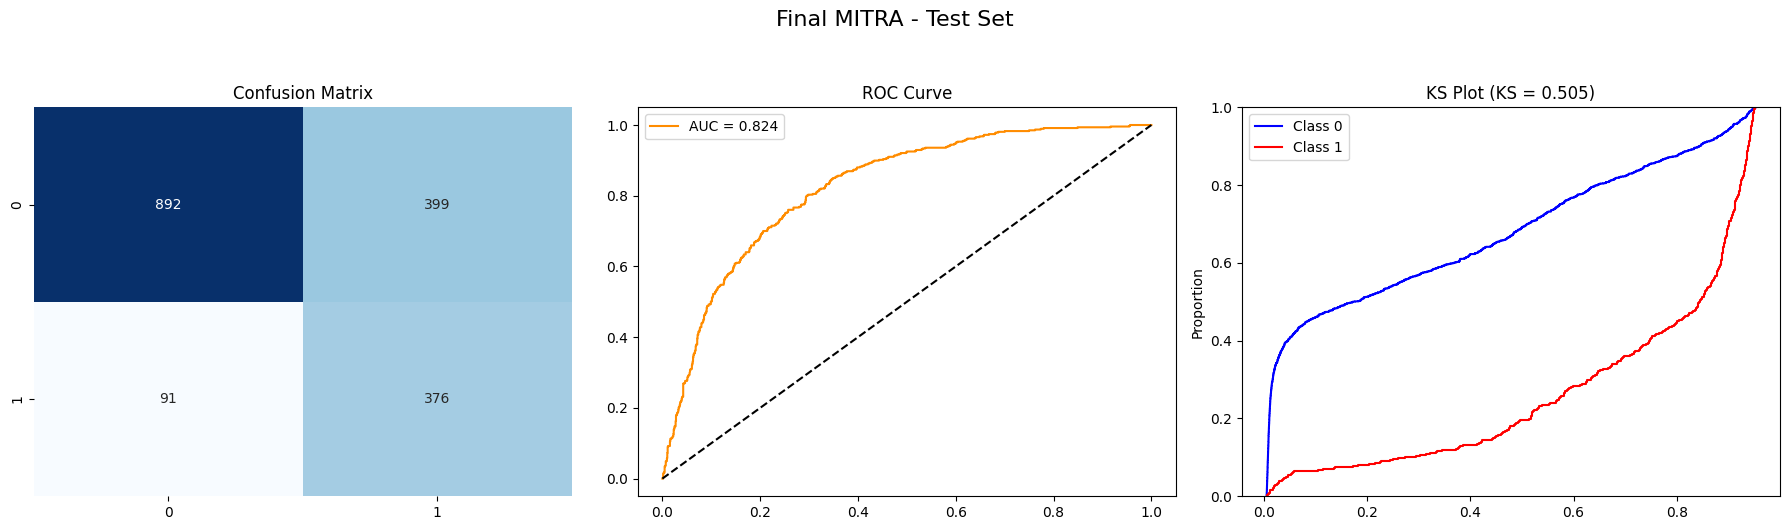

In [7]:
# Treinamento Final com os Melhores Parâmetros 
print("\nTreinando MITRA Final...")
bp = study.best_params

final_model = MitraClassifier(
    d_model=bp['d_model'],
    nhead=bp['nhead'],
    num_layers=bp['num_layers'],
    dim_feedforward=bp['dim_feedforward'],
    dropout=bp['dropout'],
    learning_rate=bp['lr'],
    batch_size=bp['batch_size'],
    max_epochs=30, # Treino longo para convergência
    device=DEVICE
)

final_model.fit(X_train_bal, y_train_bal)

print("\nRESULTADOS FINAIS - MITRA (AMAZON)")
probs_test = final_model.predict_proba(X_test)[:, 1]
preds_test = (probs_test >= 0.5).astype(int)

print(classification_report(y_test, preds_test))
print(f"AUROC Final: {roc_auc_score(y_test, probs_test):.4f}")
# KS Statistic
ks_statistic, ks_pvalue = ks_2samp(probs_test[y_test == 1], probs_test[y_test == 0])
print(f"KS Statistic: {ks_statistic:.4f}, p-value: {ks_pvalue:.4f}")
plot_model_performance(final_model, X_test, y_test, title="Final MITRA - Test Set")

###  Avaliação Final no Conjunto de Teste – MITRA

O modelo MITRA apresentou bom desempenho no conjunto de teste, com **AUROC ≈ 0.82**
e **estatística KS ≈ 0.50**, indicando capacidade consistente de separação entre
clientes churners e não churners.

O principal destaque do modelo é o **alto recall da classe positiva (~0.81)**,
o que demonstra forte capacidade de identificar clientes com risco de churn,
reduzindo significativamente a ocorrência de falsos negativos. Em contrapartida,
a **precision mais baixa (~0.49)** indica um aumento no número de falsos positivos,
refletindo um perfil mais agressivo de classificação.

Esse comportamento torna o MITRA particularmente adequado para cenários de churn
em que o custo de perder um cliente é elevado e ações de retenção possuem custo
relativamente baixo, sendo menos indicado para estratégias altamente seletivas.
